In [53]:
from sklift.datasets import fetch_hillstrom
from sklearn.datasets import fetch_openml  # or from dirty_cat.datasets if using dirty_cat
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import pandas as pd
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [ ]:
pd.DataFrame(fetch_hillstrom(target_col='visit').data) # this is our X features.

,recency,history_segment,history,mens,womens,zip_code,newbie,channel
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web
...,...,...,...,...,...,...,...,...
63995,10,2) $100 - $200,105.54,1,0,Urban,0,Web
63996,5,1) $0 - $100,38.91,0,1,Urban,1,Phone
63997,6,1) $0 - $100,29.99,1,0,Urban,1,Phone
63998,1,5) $500 - $750,552.94,1,0,Surburban,1,Multichannel


In [15]:
# Fetch the Hillstrom dataset with the target column specified
df_bunch = fetch_hillstrom(target_col='visit')
df = pd.DataFrame(df_bunch.data, columns=df_bunch.feature_names)
# df['target'] = df_bunch.target
df['treatment'] = df_bunch.treatment
df.head()


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail


### The Meta-data


In [ ]:
"""
Major columns:

visit (binary): target. 1/0 indicator, 1 = Customer visited website in the following two weeks.

conversion (binary): target. 1/0 indicator, 1 = Customer purchased merchandise in the following two weeks.

spend (float): target. Actual dollars spent in the following two weeks.

segment (str): treatment. The e-mail campaign the customer received

"""

In [ ]:
"""
Historical customer attributes at your disposal include:

Recency: Months since last purchase.

History_Segment: Categorization of dollars spent in the past year.

History: Actual dollar value spent in the past year.

Mens: 1/0 indicator, 1 = customer purchased Mens merchandise in the past year.

Womens: 1/0 indicator, 1 = customer purchased Womens merchandise in the past year.

Zip_Code: Classifies zip code as Urban, Suburban, or Rural.

Newbie: 1/0 indicator, 1 = New customer in the past twelve months.

Channel: Describes the channels the customer purchased from in the past year.

"""

## Preprocessing part

In [24]:
# Let's see null values
df.isnull().sum()

recency      0
history      0
mens         0
womens       0
zip_code     0
newbie       0
channel      0
treatment    0
dtype: int64

In [ ]:
"""
    Since the history and history_segment represent the same information, we can drop one of them.
"""

df.drop(columns=['history_segment'], inplace=True)

In [22]:
df.head(4)

,recency,history,mens,womens,zip_code,newbie,channel,treatment
0,10,142.44,1,0,Surburban,0,Phone,Womens E-Mail
1,6,329.08,1,1,Rural,1,Web,No E-Mail
2,7,180.65,0,1,Surburban,1,Web,Womens E-Mail
3,9,675.83,1,0,Rural,1,Web,Mens E-Mail


In [26]:
pd.DataFrame(df_bunch.target, columns=['visit']).value_counts()

visit
0        54606
1         9394
Name: count, dtype: int64

In [56]:
class LGBMClassifierWrapper(LGBMClassifier):
    def fit(self, X, y, **kwargs):
        eval_set = kwargs.pop('eval_set', None)

        callbacks = [lgb.early_stopping(stopping_rounds=10)]

        return super().fit(
            X, y,
            eval_set=eval_set,
            eval_metric="auc",
            callbacks=callbacks,
            **kwargs
        )
        
lgbm = LGBMClassifierWrapper(random_state=42)

In [61]:
""" Now we will use sklearn pipeline to preprocess and encode the data. Later, train a model."""

# Define our numeric columns and categorical columns
numeric_features = ['recency', 'history']
binary_features = ['mens', 'womens', 'newbie']
categorical_features = ['zip_code', 'channel', 'treatment']

# Define our column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),  # Keep numeric features as is
        ('bin', 'passthrough', binary_features),  # One-hot encode binary features
        ('cat', OneHotEncoder(handle_unknown='ignore',sparse_output=False), categorical_features)  # One-hot encode categorical features
    ],
    remainder='drop'  # Drop any other columns not specified
)

# Prepare the data
X = df
Y = pd.DataFrame(df_bunch.target, columns=['visit'])

# Train-test split
# First split: train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

# Then further split train and val
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp,random_state=42)

# Manually transform the data using the preprocessor
X_val_transformed = preprocessor.fit(X_train).transform(X_val)
X_train_transformed = preprocessor.transform(X_train)

# Create a pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgbm)
])

# Fit the model
pipeline.fit(
    X_train, y_train.values.ravel(),
    classifier__eval_set=[(X_val_transformed, y_val.values.ravel())]
)


# Predict probaibilities on the test set
y_pred_proba = pipeline.predict_proba(X_test) # Get probabilities 

[LightGBM] [Info] Number of positive: 5636, number of negative: 32764
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 38400, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.146771 -> initscore=-1.760156
[LightGBM] [Info] Start training from score -1.760156
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's auc: 0.639698	valid_0's binary_logloss: 0.401666


c:\Users\tonwa\anaconda3\envs\datasci\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifierWrapper was fitted with feature names
  warnings.warn(


In [62]:
y_pred_proba = y_pred_proba[:, 1]  # Get probabilities for the positive class (visit = 1)

In [63]:
y_pred_proba

array([0.16799331, 0.1663051 , 0.16514454, ..., 0.08615804, 0.21426673,
       0.1644115 ], shape=(12800,))

## Evaluation

In [64]:
# AUC Score
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc:.4f}")

AUC Score: 0.6468


In [65]:
# GINI Coefficient
gini_coefficient = 2 * auc - 1
print(f"Gini Coefficient: {gini_coefficient:.4f}")

Gini Coefficient: 0.2935


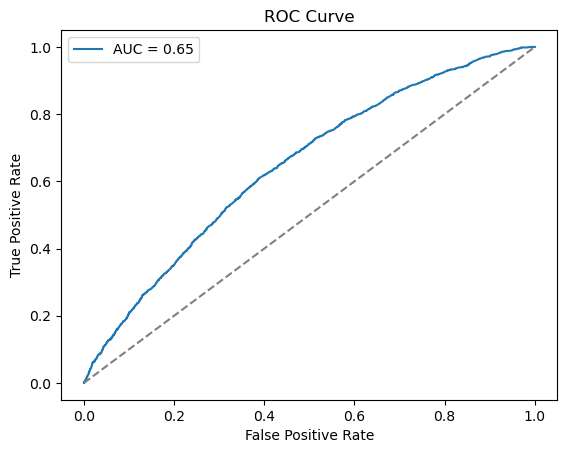

In [66]:
# plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
